# Импорт библиотек

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Загрузка данных

In [2]:
transformations = transforms.Compose([
  transforms.ToTensor()
])

batch_size = 64

train_dataset = MNIST(
    root="./",
    train=True,
    transform=transformations,
    download=True
)

test_dataset = MNIST(
    root="./",
    train=False,
    transform=transformations,
    download=True
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST\raw



## Задание 1. Загрузите данные с помощью  ```DataLoader```.

In [8]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=16, drop_last=True)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=True, num_workers=16, drop_last=True)

# Автоэнкодер

## Задание 2. Используя архитектуру энкодера и декодерора, указанную в уроке, допишите класс ```SimpleAutoEncoder```.  

In [9]:
# Creating a PyTorch class
# 28*20 ==> 9 ==> 28*20

class SimpleAutoEncoder(nn.Module):
  def __init__(self, feature_size=2):
    super().__init__()
    # Building an linear encoder with Linear
    # layer followed by Relu activation function
    # 560 ==> 9
    self.encoder = torch.nn.Sequential(
        torch.nn.Conv2d(1, 32, 4, 2, 1),
        torch.nn.LeakyReLU(),
    )
      
    # Building an linear decoder with Linear
    # layer followed by Relu activation function
    # The Sigmoid activation function
    # outputs the value between 0 and 1
    # 9 ==> 560
    self.decoder = torch.nn.Sequential(
        torch.nn.Linear(9, 18),
        torch.nn.ReLU(),
        torch.nn.Linear(18, 36),
        torch.nn.ReLU(),
        torch.nn.Linear(36, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, 28 * 20),
        torch.nn.Sigmoid()
    )

  def encode(self, x):
    x = self.encoder(x)
    return x
  
  def decode(self, x):
    x = self.decoder(x)
    return x

  def forward(self, x):
    z = self.encode(x)
    x_pred = self.decode(z)
    return x_pred

## Обучение модели

In [10]:
feature_size = 2
lr = 0.0005
nrof_epochs = 30
loss_fn_name = "rmse"
device = "cuda"

In [11]:
model = SimpleAutoEncoder(feature_size)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

loss_fn = {
    "mse": nn.MSELoss(),
    "rmse": nn.MSELoss(),
    "cross-entropy": nn.CrossEntropyLoss()
}[loss_fn_name]

min_loss = 10e6

In [12]:
model.train()
for epoch in range(nrof_epochs):
  loss = 0.
  for i_batch, (x, _) in enumerate(train_loader):
    optimizer.zero_grad()

    x = x.to(device)
    x_pred = model(x)
      
    loss_batch = loss_fn(x_pred, x)
    if loss_fn_name == "rmse":
        loss_batch = torch.sqrt(loss_batch)
    loss_batch.backward()
    optimizer.step()

    loss += loss_batch
    
  loss = loss / (i_batch + 1)
  print(f"Epoch {epoch+1}/{nrof_epochs} | Loss {loss.item()}")

  if loss < min_loss:
      min_loss = loss
      torch.save(model.state_dict(), "./model.pt")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1792x28 and 560x128)

## Валидация модели

In [ ]:
model.eval()
loss = 0.
for i_batch, (x, _) in enumerate(test_loader):
  x = x.to(device)
  x_pred = model(x)
    
  loss_batch = loss_fn(x_pred, x)
  if loss_fn_name == "rmse":
    loss_batch = torch.sqrt(loss_batch)
  loss += loss_batch

loss = loss / (i_batch + 1)
print(f"Test set lost: {loss.item()}")

Test set lost: 0.19050413370132446


In [ ]:
def rescale(x):
  x = x - np.min(x, (1, 2, 3)).reshape(-1, 1, 1, 1)
  x = x / np.max(x, (1, 2, 3)).reshape(-1, 1, 1, 1)
  return (x*255).astype(np.uint8)


def torch_to_numpy(x):
  x = x.detach().cpu().numpy()
  x = x.transpose(0, 2, 3, 1)
  x = rescale(x)
  return x
  

def make_samples_grid(x, x_pred=None, grid_shape=6*6):
  x = torch_to_numpy(x)
  if x_pred is not None:
    x_pred = torch_to_numpy(x_pred)
  
  n = 2 if x_pred is not None else 1

  H, W = x.shape[1:3]
  m = int(np.sqrt(grid_shape))
  grid = np.zeros((H*m, W*m), dtype=np.uint8)

  i = 0
  for row in range(m):
    for col in range(m):
      sample = [x, x_pred][i%n]
      grid[H*row:H*(row+1), W*col:W*(col+1)] = sample[int(i//n)][..., 0]
      i += 1
  return grid

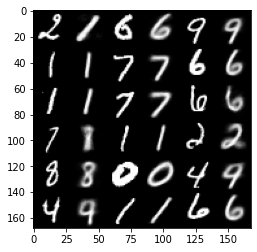

In [ ]:
# Реконструкция нескольких изображений из тестового датасета
indices = np.arange(len(test_dataset))
np.random.shuffle(indices)

x = []
y = []
for index in indices:
  image, label = test_dataset[index]
  x.append(image)
  y.append(label)

x = torch.stack(x)
x = x.to(device)
x_pred = model(x)

grid = make_samples_grid(x, x_pred)
plt.imshow(grid, cmap="gray")
plt.show()

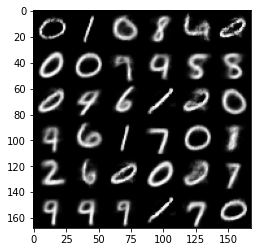

In [ ]:
# Генерация сэмплов из шума
random = np.sqrt(10)*torch.randn((36, 2))
random = random.to(device)
random_samples = model.decode(random)

grid = make_samples_grid(random_samples)
plt.imshow(grid, cmap="gray")
plt.show()